In [1]:
import configparser
import numpy as np
from datetime import datetime
import pickle
import psycopg2

import pandas as pd
import geopandas as gpd
import psycopg2
from osgeo import gdal, gdal_array
from skimage.draw import polygon2mask
import matplotlib.pyplot as plt

from tathu.io import pgis
from tathu import visualizer
from tathu.utils import (
    extractPeriods,
    file2timestamp,
    getGeoT,
    geo2grid,
)
from tathu.geometry.transform import shapely2ogr
from tathu.geometry.utils import extractCoordinates
from tathu.constants import LAT_LON_WGS84
from tathu.io.pgis import bytea2nparray, _adapt_array

from read_sipam_cappis_cptec import read_simple_cappi

# Tell pgis how to deal with numpy arrays
psycopg2.extensions.register_adapter(np.ndarray, _adapt_array)

from my_secrets import postgis_pwd

In [2]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


### Fill classification

In [3]:
f = db.load(names[0], ['gld'])
np.sum([x for x in [None, None] if x is not None])

0.0

In [3]:
for name in names[:5]:
    fam = db.load(
        name, ["count", "max", "event"]
    )
    # Getting data
    timestamps = fam.getTimestamps()
    events = fam.getAttribute("event")
    max_area = np.max(fam.getAttribute("count"))
    max_z = np.max(fam.getAttribute("max"))
    duration = timestamps[-1] - timestamps[0]
    init_ts = timestamps[0]
    print(init_ts)
    
    if max_area <= 1000:
        clf_area = 'small'
    else:
        clf_area = 'large'
    
    if max_z >= 55:
        clf_z = 'intense'
    else:
        clf_z = 'no_intense'
    
    if ('SPLIT' in events) | ('MERGE' in events):
        clf_life = 'with_splitmerge'
    else:
        clf_life = 'no_splitmerge'
    
    if duration.total_seconds() <= 3600:
        clf_duration = 'short_span'
    elif (duration.total_seconds() > 3600) & (duration.total_seconds() <= 3600*3):
        clf_duration = "medium_span"
    else:
        clf_duration = 'large_span'
        
    if init_ts.month in [1,2,3]:
        clf_season = 'wet'
    elif init_ts.month in [8, 9, 10]:
        clf_season = 'dry'
    elif init_ts.month in [11, 12]:
        clf_season = 'dry-to-wet'
    else:
        clf_season = ''
    
    if init_ts.hour in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]:
        clf_timeofday = 'diurnal'
    else:
        clf_timeofday = 'nocturnal'
    
    print(duration)
    print(events)
    print(clf_life)
    print(clf_duration)
    print(clf_season)
    print(clf_timeofday)

2015-11-26 05:12:00
0:36:00
['SPONTANEOUS_GENERATION', 'SPLIT', 'MERGE', 'CONTINUITY']
with_splitmerge
short_span
dry-to-wet
nocturnal
2015-12-17 18:36:00
0:12:00
['SPONTANEOUS_GENERATION', 'CONTINUITY']
no_splitmerge
short_span
dry-to-wet
nocturnal
2014-06-12 18:48:00
1:00:00
['SPONTANEOUS_GENERATION', 'CONTINUITY', 'CONTINUITY', 'MERGE', 'CONTINUITY', 'SPLIT']
with_splitmerge
short_span

nocturnal
2015-11-23 15:48:00
0:12:00
['SPONTANEOUS_GENERATION', 'CONTINUITY']
no_splitmerge
short_span
dry-to-wet
diurnal
2014-11-12 14:00:00
0:48:00
['SPONTANEOUS_GENERATION', 'CONTINUITY', 'SPLIT', 'MERGE', 'CONTINUITY']
with_splitmerge
short_span
dry-to-wet
diurnal


### Correlations

In [3]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init25, totaerosol25_1_cm3, totccn25_1_cm3,"
    " cape25_j_kg, cin25_j_kg, blrh25_pc, lvws25_m_s, ufaerosol25_1_cm3, wcd25_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [4]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'totccn': totccn,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxviwl,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name')
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month
systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'totccn', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday',
       'clf_lightning'])
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'ultrafine aerosols', 
    'total CCNs', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]

In [5]:
systems.columns

Index(['duration', 'date_init', 'init hour', 'init month', 'max area',
       'max reflectivity', 'max echotop 0 dBZ', 'max echotop 20 dBZ',
       'max echotop 40 dBZ', 'GLD strokes', 'total aerosols',
       'ultrafine aerosols', 'total CCNs', 'CAPE', 'CIN',
       'bl relative humidity', 'v-wind shear', 'warm cloud depth', 'max VIL',
       'max VII', 'max VIWL', 'area', 'reflectivity', 'lifespan',
       'sys duration', 'season', 'time of day', 'electrical activity'],
      dtype='object')

In [6]:
len(systems.columns)

28

In [7]:
systems['lifespan']

name
4cf98e6c-970d-478e-b402-7fc3b8c10e2b      no_splitmerge
ac592abe-af33-46b5-b145-c1de80073666    with_splitmerge
457531a7-9b7a-4afa-8e82-ce8fbcfc0831      no_splitmerge
276778fa-5e23-4293-93d2-290e14cc3a7e      no_splitmerge
51613f72-38d5-4571-bfe7-858f33935e1b      no_splitmerge
                                             ...       
226fbae5-7f99-440d-9c5d-cf26e46a7073      no_splitmerge
64ff44b3-a809-4b6f-97b9-f28448ac7c16      no_splitmerge
630bed79-3acb-4ade-b78f-b5e0b6077866    with_splitmerge
07865dad-489f-4cbd-b1a2-4da3363cf86a      no_splitmerge
518673df-8a1d-4887-a3e8-aad09611083b    with_splitmerge
Name: lifespan, Length: 5976, dtype: object

In [8]:
systems.describe()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,GLD strokes,total aerosols,ultrafine aerosols,total CCNs,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,max VIL,max VII,max VIWL
count,5976.000000,386.000000,386.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,5976.000000,386.000000,386.000000,277.000000,386.000000,386.000000,386.000000,386.000000,335.000000,5976.000000,5976.000000,5976.000000
mean,70.327309,9.875648,6.474093,604.390730,53.674277,13.215361,12.143072,7.293675,55.051874,2374.920289,820.100692,569.046378,2408.766948,-25.677781,81.758376,-2.390708,4.281382,0.297571,0.184827,0.182629
std,64.798119,7.552076,3.214513,645.923541,3.376442,2.063179,2.434366,2.131321,253.094633,2441.029891,871.820391,564.742974,1532.117769,36.634981,8.859880,3.302603,0.531538,0.061124,0.076110,0.015696
min,0.000000,0.000000,1.000000,101.000000,43.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-30.380970,-214.556920,51.800180,-10.848417,0.407189,0.031633,0.000000,0.031633
25%,24.000000,5.000000,4.000000,267.000000,51.350000,12.000000,10.000000,6.000000,0.000000,948.171350,242.863905,213.113860,1246.654250,-43.001580,75.538363,-4.456277,4.185454,0.257217,0.129105,0.174764
50%,60.000000,7.000000,6.000000,412.000000,53.480000,14.000000,12.000000,7.000000,3.000000,1656.081050,549.865100,417.855470,2237.752500,-6.415871,82.332035,-2.487363,4.396558,0.301533,0.199272,0.183118
75%,96.000000,18.000000,9.000000,688.250000,55.730000,15.000000,14.000000,8.000000,21.000000,2976.267600,1070.985800,736.367200,3589.396500,0.000000,87.864213,-0.840049,4.544701,0.341547,0.244234,0.191936
max,540.000000,23.000000,12.000000,11931.000000,67.760000,15.000000,15.000000,15.000000,8831.000000,19710.900000,6224.416500,4732.545400,6351.676000,0.000000,99.871080,12.098212,7.027228,0.463247,0.360144,0.226116


In [9]:
systems.corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,GLD strokes,total aerosols,ultrafine aerosols,total CCNs,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,max VIL,max VII,max VIWL
duration,1.000000,0.049458,-0.004449,0.015164,-0.006333,0.027347,0.024613,-0.006753,0.005663,0.039710,-0.000056,0.023418,0.071090,-0.001372,-0.106699,-0.025021,-0.079818,0.016148,0.020351,0.003975
init hour,0.049458,1.000000,-0.064222,0.028514,-0.065867,-0.007992,-0.063738,-0.025017,-0.005945,-0.061817,0.002347,0.003745,0.309389,0.327895,-0.081030,0.002417,-0.382041,-0.042050,-0.041389,-0.020158
init month,-0.004449,-0.064222,1.000000,-0.142310,0.396235,0.054495,0.122909,0.436818,0.143077,0.353186,-0.031478,0.427130,0.082525,-0.163547,-0.385601,-0.031403,-0.026042,0.274210,0.169577,0.421037
max area,0.015164,0.028514,-0.142310,1.000000,0.030742,0.182139,0.171781,0.075273,0.240226,-0.083756,0.060547,-0.075443,-0.026187,0.079774,0.079398,0.047120,0.011082,0.137227,0.183717,0.008732
max reflectivity,-0.006333,-0.065867,0.396235,0.030742,1.000000,0.145182,0.232091,0.526400,0.247524,0.326814,0.090998,0.206631,0.162674,-0.054331,-0.296909,0.065954,0.090664,0.346723,0.270922,0.518771
max echotop 0 dBZ,0.027347,-0.007992,0.054495,0.182139,0.145182,1.000000,0.876147,0.470622,0.168859,0.046220,-0.128306,0.066787,0.022633,-0.080884,-0.108132,0.120300,0.065261,0.838780,0.903919,0.569472
max echotop 20 dBZ,0.024613,-0.063738,0.122909,0.171781,0.232091,0.876147,1.000000,0.610143,0.222754,0.113258,-0.101240,0.097775,0.024339,-0.098314,-0.149988,0.159460,0.110352,0.915578,0.925188,0.652390
max echotop 40 dBZ,-0.006753,-0.025017,0.436818,0.075273,0.526400,0.470622,0.610143,1.000000,0.416331,0.329169,-0.008185,0.352824,0.134808,-0.127612,-0.354399,0.037111,0.055194,0.759200,0.658635,0.779352
GLD strokes,0.005663,-0.005945,0.143077,0.240226,0.247524,0.168859,0.222754,0.416331,1.000000,0.066346,0.009528,0.141470,0.040349,-0.093634,-0.181561,0.061618,0.010346,0.299142,0.281797,0.242033
total aerosols,0.039710,-0.061817,0.353186,-0.083756,0.326814,0.046220,0.113258,0.329169,0.066346,1.000000,0.567056,0.747517,0.189768,-0.096689,-0.274574,-0.134581,0.030872,0.189155,0.128218,0.289236


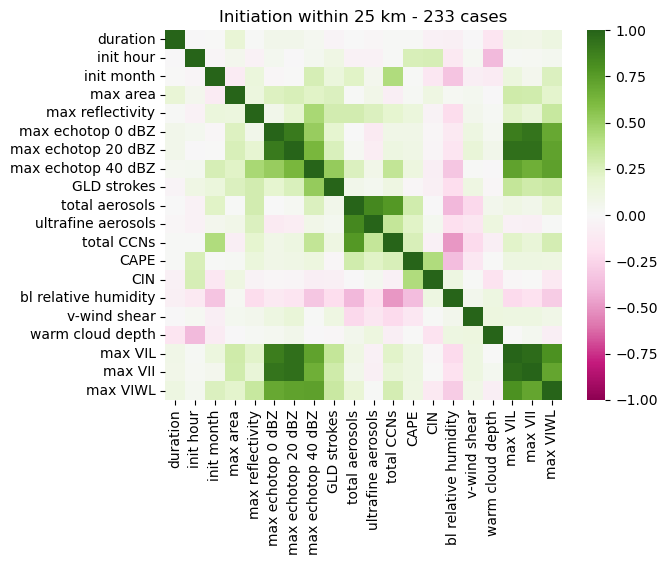

In [10]:
import seaborn as sns

sns.heatmap(systems.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)


In [9]:
systems.columns

Index(['duration', 'date_init', 'init hour', 'init month', 'max area',
       'max reflectivity', 'max echotop 0 dBZ', 'max echotop 20 dBZ',
       'max echotop 40 dBZ', 'GLD strokes', 'total aerosols',
       'ultrafine aerosols', 'total CCNs', 'CAPE', 'CIN',
       'bl relative humidity', 'v-wind shear', 'max VIL', 'max VII', 'area',
       'reflectivity', 'lifespan', 'sys duration', 'season', 'time of day',
       'electrical activity'],
      dtype='object')

In [10]:
systems.drop(columns=['date_init'])

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,GLD strokes,total aerosols,...,v-wind shear,max VIL,max VII,area,reflectivity,lifespan,sys duration,season,time of day,electrical activity
name,,,,,,,,,,,,,,,,,,,,,
4cf98e6c-970d-478e-b402-7fc3b8c10e2b,36.0,NaN,NaN,819.0,45.040000,11.0,8.0,5.0,0.0,NaN,...,NaN,0.224813,0.396912,small,no_intense,no_splitmerge,short_span,,diurnal,without_lightning
ac592abe-af33-46b5-b145-c1de80073666,12.0,NaN,NaN,593.0,46.290000,13.0,10.0,5.0,1.0,NaN,...,NaN,0.247301,0.436614,small,no_intense,with_splitmerge,short_span,wet,nocturnal,with_lightning
457531a7-9b7a-4afa-8e82-ce8fbcfc0831,60.0,20.0,8.0,775.0,56.330000,7.0,6.0,6.0,90.0,2976.2676,...,-4.879368,0.145503,0.256888,small,intense,no_splitmerge,short_span,dry,nocturnal,with_lightning
276778fa-5e23-4293-93d2-290e14cc3a7e,12.0,NaN,NaN,303.0,55.610000,13.0,11.0,8.0,4.0,NaN,...,NaN,0.309360,0.546180,small,intense,no_splitmerge,medium_span,dry,nocturnal,with_lightning
51613f72-38d5-4571-bfe7-858f33935e1b,48.0,NaN,NaN,458.0,60.360000,15.0,15.0,10.0,32.0,NaN,...,NaN,0.409005,0.722106,small,intense,no_splitmerge,medium_span,dry-to-wet,diurnal,with_lightning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226fbae5-7f99-440d-9c5d-cf26e46a7073,48.0,NaN,NaN,190.0,58.599995,14.0,13.0,8.0,6.0,NaN,...,NaN,0.325503,0.574683,small,intense,no_splitmerge,short_span,dry-to-wet,diurnal,with_lightning
64ff44b3-a809-4b6f-97b9-f28448ac7c16,120.0,NaN,NaN,307.0,53.570000,10.0,10.0,6.0,0.0,NaN,...,NaN,0.243829,0.430485,small,no_intense,no_splitmerge,short_span,dry,diurnal,without_lightning
630bed79-3acb-4ade-b78f-b5e0b6077866,12.0,20.0,3.0,328.0,54.570000,13.0,12.0,5.0,6.0,1841.2075,...,2.707839,NaN,NaN,small,no_intense,with_splitmerge,medium_span,wet,diurnal,with_lightning


In [11]:
systems.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_25km.csv')

<AxesSubplot:xlabel='total aerosols', ylabel='max reflectivity'>

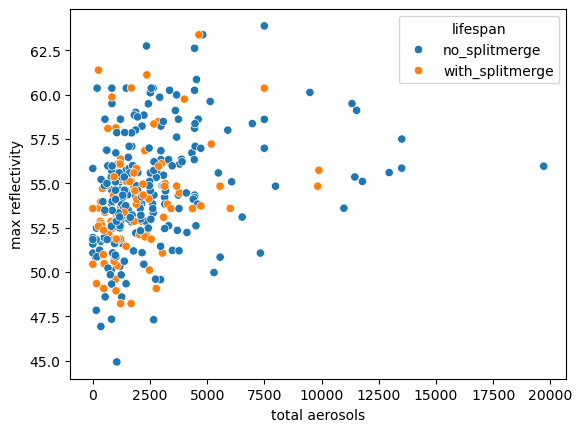

In [47]:
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="lifespan")

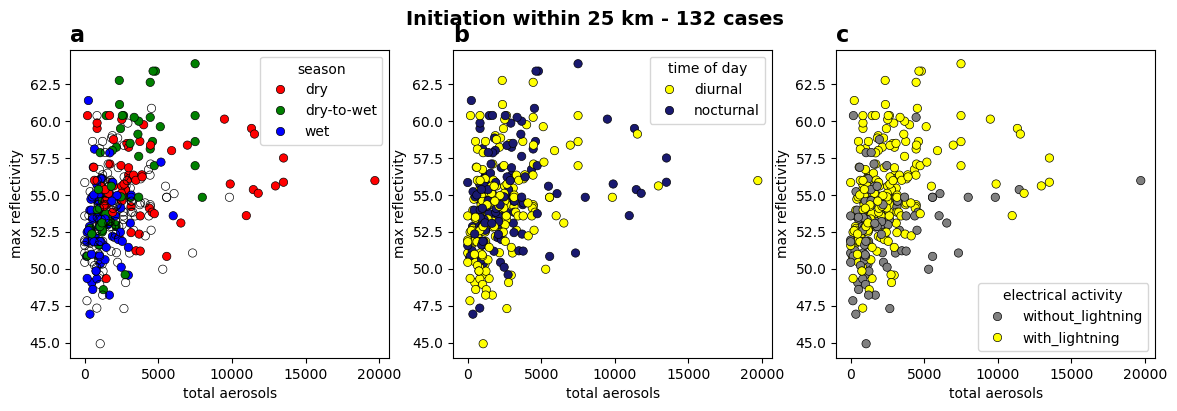

In [57]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
fig.suptitle("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases", size=14, fontweight="bold")
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [12]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [13]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init10, totaerosol10_1_cm3, totccn10_1_cm3,"
    " cape10_j_kg, cin10_j_kg, blrh10_pc, lvws10_m_s, ufaerosol10_1_cm3, wcd10_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [14]:
systems_10 = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'totccn': totccn,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxvil,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name')
systems_10['hour_init'] = systems_10.date_init.dt.hour
systems_10['month_init'] = systems_10.date_init.dt.month
systems_10 = systems_10.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'totccn', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday',
       'clf_lightning'])
systems_10.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'ultrafine aerosols', 
    'total CCNs', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]

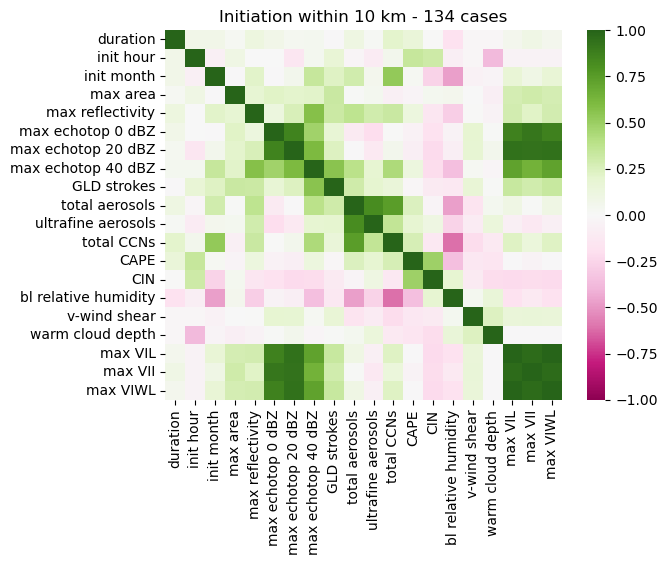

In [15]:
import seaborn as sns

sns.heatmap(systems_10.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [17]:
systems_10.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_10km.csv')

In [14]:
systems_10.corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,GLD strokes,total aerosols,ultrafine aerosols,total CCNs,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,max VIL,max VII
duration,1.000000,0.081583,0.111783,0.021164,0.004557,0.021308,0.026739,-0.007451,0.008316,0.164235,0.023666,0.149122,0.135634,-0.005929,-0.106483,-0.062452,0.000511,0.008949,0.008949
init hour,0.081583,1.000000,-0.097121,0.054963,-0.034237,-0.045211,-0.158470,-0.056443,-0.015654,-0.147240,-0.103468,0.059749,0.256774,0.349253,-0.027750,-0.036598,-0.387284,-0.105485,-0.105485
init month,0.111783,-0.097121,1.000000,-0.099471,0.420605,0.089759,0.203556,0.488520,0.186460,0.455950,0.011326,0.524938,0.136620,-0.195068,-0.498741,-0.029991,-0.030980,0.348761,0.348761
max area,0.021164,0.054963,-0.099471,1.000000,0.030742,0.182139,0.171781,0.075273,0.240226,-0.136066,0.036805,-0.070044,-0.071800,0.011395,0.095121,0.002808,-0.040812,0.153211,0.153211
max reflectivity,0.004557,-0.034237,0.420605,0.030742,1.000000,0.145182,0.232091,0.526400,0.247524,0.410447,0.186841,0.323056,0.233630,-0.045751,-0.358656,-0.017186,-0.043015,0.384886,0.384886
max echotop 0 dBZ,0.021308,-0.045211,0.089759,0.182139,0.145182,1.000000,0.876147,0.470622,0.168859,0.106918,-0.151235,0.007649,0.050757,-0.170247,-0.115965,0.161934,0.039686,0.836271,0.836271
max echotop 20 dBZ,0.026739,-0.158470,0.203556,0.171781,0.232091,0.876147,1.000000,0.610143,0.222754,0.212092,-0.090945,0.061064,0.036233,-0.202608,-0.167884,0.146193,0.062084,0.910252,0.910252
max echotop 40 dBZ,-0.007451,-0.056443,0.488520,0.075273,0.526400,0.470622,0.610143,1.000000,0.416331,0.475692,0.105668,0.432363,0.227438,-0.168734,-0.416022,0.017750,-0.013324,0.764410,0.764410
GLD strokes,0.008316,-0.015654,0.186460,0.240226,0.247524,0.168859,0.222754,0.416331,1.000000,0.095961,0.073199,0.150469,0.057475,-0.112587,-0.190523,0.072456,0.033485,0.270828,0.270828
total aerosols,0.164235,-0.147240,0.455950,-0.136066,0.410447,0.106918,0.212092,0.475692,0.095961,1.000000,0.471609,0.748597,0.242683,-0.123884,-0.405641,-0.092342,0.063216,0.312383,0.312383


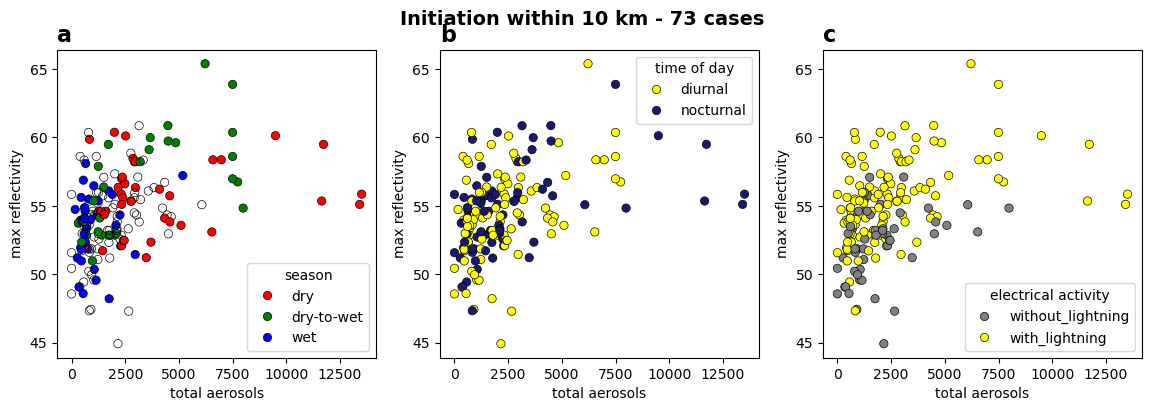

In [56]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
fig.suptitle("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases", size=14, fontweight="bold")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [ ]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]
# -- CS Max area
query = "SELECT MAX(count) FROM systems_filtered GROUP BY name"
maxplots = [q[0] for q in db.query(query)]
# -- Cl max Z
query = "SELECT max FROM systems_filtered ORDER BY name, date_time ASC"
zmax = [q[0] for q in db.query(query)]
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [ ]:
systems = pd.DataFrame(
    {
        'name': names,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
        'totaerosol': totaerosol,
    }
).dropna(subset=["totaerosol"]).drop(columns=['totaerosol']).set_index('name')

In [ ]:
systems

In [ ]:
type(systems.clf_season[2])

In [ ]:
systems.corr()